In [3]:
from keras.layers import BatchNormalization, Dense, Dropout, LeakyReLU
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# Reading and preprocessing
data = './dataset/test3.csv'
df = pd.read_csv(data)


In [5]:
# One-hot encoding
categorical_cols = ['Item_Name', 'Category', 'Weather']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [6]:
# Calculate sales diff
df['sales'] = df['Predicted_sales'].diff().apply(lambda x: 1 if x > 0 else 0)
df.dropna(inplace=True)

In [7]:
# Dropping unnecessary columns
df.drop(columns=['Item_ID', 'Date', 'Predicted_sales'], inplace=True)

In [8]:
X = df.drop('sales', axis=1).values
y = df['sales'].values

In [9]:
# Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
# Oversampling
smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_resample(X, y)

In [11]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.4, random_state=0)

In [12]:
# Model architecture
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(256))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(128))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=28, callbacks=[early_stopping])

Epoch 1/200
73/73 [==============================] - 3s 14ms/step - loss: 0.4943 - accuracy: 0.5178 - val_loss: 0.4965 - val_accuracy: 0.5052
Epoch 2/200
73/73 [==============================] - 1s 9ms/step - loss: 0.4772 - accuracy: 0.5449 - val_loss: 0.4890 - val_accuracy: 0.5148
Epoch 3/200
73/73 [==============================] - 1s 8ms/step - loss: 0.4563 - accuracy: 0.5538 - val_loss: 0.4775 - val_accuracy: 0.5496
Epoch 4/200
73/73 [==============================] - 1s 8ms/step - loss: 0.4448 - accuracy: 0.5800 - val_loss: 0.4614 - val_accuracy: 0.5614
Epoch 5/200
73/73 [==============================] - 1s 8ms/step - loss: 0.4224 - accuracy: 0.6027 - val_loss: 0.4440 - val_accuracy: 0.5791
Epoch 6/200
73/73 [==============================] - 1s 8ms/step - loss: 0.4088 - accuracy: 0.6170 - val_loss: 0.4225 - val_accuracy: 0.6050
Epoch 7/200
73/73 [==============================] - 1s 9ms/step - loss: 0.3994 - accuracy: 0.6229 - val_loss: 0.4026 - val_accuracy: 0.6265
Epoch 8/200


In [15]:
# Evaluation
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

43/43 [==============================] - 0s 2ms/step - loss: 0.2541 - accuracy: 0.7485
Validation Accuracy: 74.85%


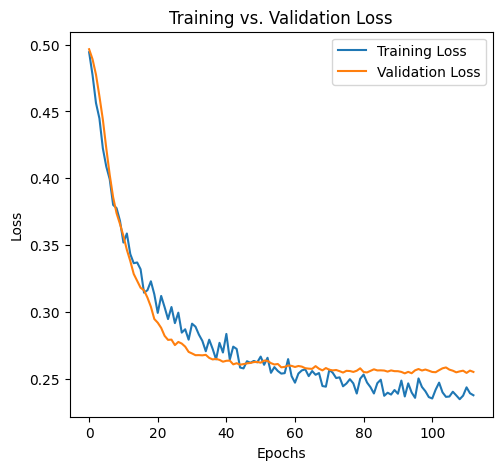

In [16]:
# Plotting loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

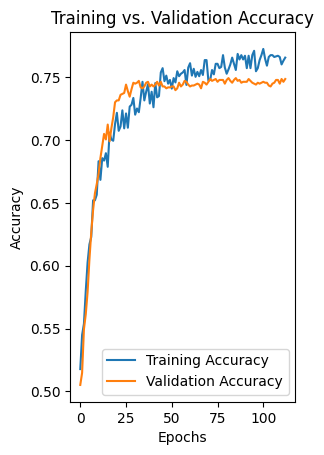

In [17]:
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [18]:
# Predictions
y_pred = model.predict(X_val)
y_pred_class = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# 1. Confusion Matrix
cm = confusion_matrix(y_val, y_pred_class)

43/43 [==============================] - 0s 3ms/step


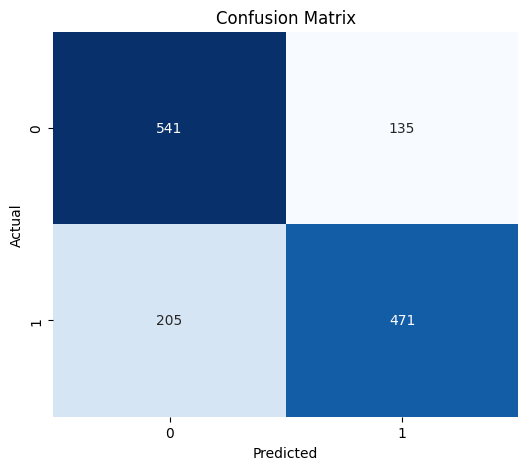

In [19]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

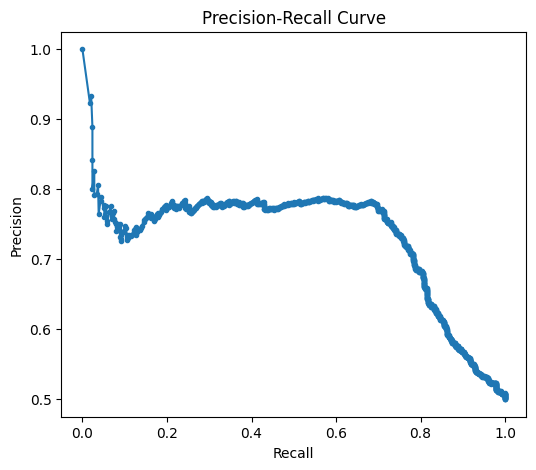

In [21]:
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

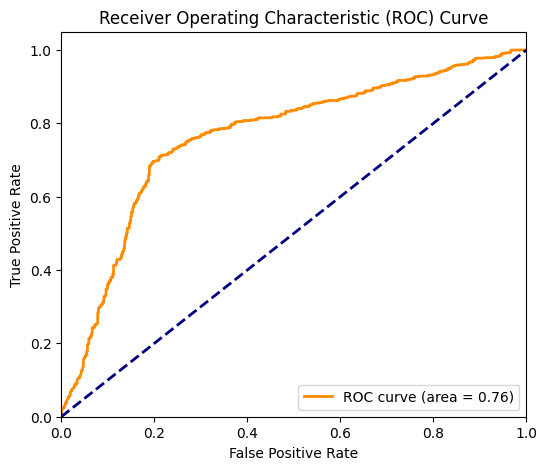

In [22]:
# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

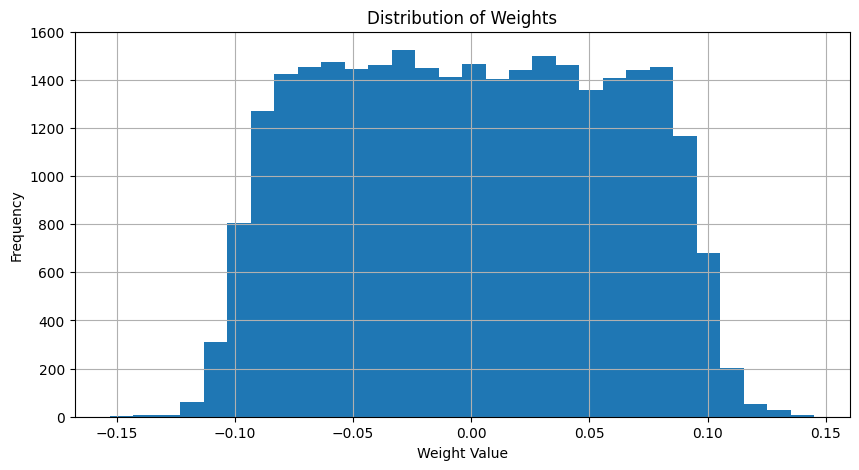

In [23]:
weights = model.layers[0].get_weights()[0]
plt.figure(figsize=(10, 5))
plt.hist(weights.flatten(), bins=30)
plt.title('Distribution of Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [24]:
stats = df.describe()

print(stats)

       Last_Month_Sales     Capacity  Last_Year_Sales  Temperature  \
count       2999.000000  2999.000000      2999.000000  2999.000000   
mean          74.326776   102.163721        70.758586    40.940313   
std            9.053944     8.447432         8.187089     5.348505   
min           12.000000    40.000000         9.000000    32.000000   
25%           71.000000    99.000000        68.000000    36.000000   
50%           71.000000    99.000000        68.000000    41.000000   
75%           82.000000   109.000000        77.000000    45.000000   
max           90.000000   116.000000        83.000000    50.000000   

             sales  
count  2999.000000  
mean      0.436812  
std       0.496074  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000  


In [25]:
df.describe()

,Last_Month_Sales,Capacity,Last_Year_Sales,Temperature,sales
count,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000
mean,74.326776,102.163721,70.758586,40.940313,0.436812
std,9.053944,8.447432,8.187089,5.348505,0.496074
min,12.000000,40.000000,9.000000,32.000000,0.000000
25%,71.000000,99.000000,68.000000,36.000000,0.000000
50%,71.000000,99.000000,68.000000,41.000000,0.000000
75%,82.000000,109.000000,77.000000,45.000000,1.000000
max,90.000000,116.000000,83.000000,50.000000,1.000000


In [29]:
# User input
item_no = int(input("Enter the item number for which you want to predict future sales: "))

# Ensure the item_no exists in the data
while item_no not in item_ids:
    item_no = int(input(f"Item number {item_no} does not exist. Please enter a valid item number: "))

# Extract data for the specific item_no
item_idx = list(item_ids).index(item_no)
latest_data = X[item_idx].reshape(1, -1)

# Predict future sales
predicted_sales_scaled = model.predict(latest_data)

# Convert the scaled prediction back to the original sales value
predicted_sales = scaler_y.inverse_transform(predicted_sales_scaled)[0][0]

# Display predictions
print(f"Predicted future sales for item {item_no}: {predicted_sales:.2f}")

NameError: name 'item_ids' is not defined